In [ ]:
# install tools 
!pip install transformers==4.28.0 datasets evaluate seqeval
!pip install datasets sentence-transformers 

# Assignment 1: Zero-shot intent recognition (due date: June 16)

In this assignment, you'll explore a multi-lingual NLU dataset and implement key components of the zero-shot intent recognition pipeline. By taking basic exploration steps and utilizing zero-shot techniques, you'll gain a deeper understanding of the setup and main challenges. 

In [2]:
# First download the MASSIVE dataset
from datasets import load_dataset
dataset = load_dataset("AmazonScience/massive")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset massive downloaded and prepared to /root/.cache/huggingface/datasets/AmazonScience___massive/all/1.0.0/71d360eb7d7a18565ff8c10609cebf714fce3cc390e173ba5b02ffd48543cdc1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset is split in three parts: train, validation, test.

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 587214
    })
    validation: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 103683
    })
    test: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 151674
    })
})

Each instance has an id, is labelled with language tag (```locale```), split (```partition```), high-level class (```scenario```), low-level class (```intent```), slots and some labelling artifacts that we can ignore for now. 

The utterance is stored in the ```utt``` field. 


In [4]:
dataset['train']

Dataset({
    features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
    num_rows: 587214
})

The dataset is multilingual. Here is a instance in Myanmar.

In [5]:
dataset['train'][0] # 

{'id': '1',
 'locale': 'mn-MN',
 'partition': 'train',
 'scenario': 16,
 'intent': 48,
 'utt': 'тавдахад есөн цагт намайг сэрээгээрэй',
 'annot_utt': '[date : тавдахад] [time : есөн цагт] намайг сэрээгээрэй',
 'worker_id': '16',
 'slot_method': {'slot': ['time', 'date'],
  'method': ['translation', 'translation']},
 'judgments': {'worker_id': ['5', '4', '2'],
  'intent_score': [1, 1, 1],
  'slots_score': [1, 1, 1],
  'grammar_score': [3, 3, 4],
  'spelling_score': [1, 2, 2],
  'language_identification': ['target', 'target', 'target']}}

For the sake of time, let's load the English section of the dataset. You should notice that this time the dataset is magnitude smaller.

In [6]:
dataset = load_dataset("AmazonScience/massive", "en-US")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset massive downloaded and prepared to /root/.cache/huggingface/datasets/AmazonScience___massive/en-US/1.0.0/71d360eb7d7a18565ff8c10609cebf714fce3cc390e173ba5b02ffd48543cdc1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDictionary ```dataset``` consists of three variables of type ```Dataset```.

In [7]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

In [8]:
dataset['train'].features

{'id': Value(dtype='string', id=None),
 'locale': Value(dtype='string', id=None),
 'partition': Value(dtype='string', id=None),
 'scenario': ClassLabel(names=['social', 'transport', 'calendar', 'play', 'news', 'datetime', 'recommendation', 'email', 'iot', 'general', 'audio', 'lists', 'qa', 'cooking', 'takeaway', 'music', 'alarm', 'weather'], id=None),
 'intent': ClassLabel(names=['datetime_query', 'iot_hue_lightchange', 'transport_ticket', 'takeaway_query', 'qa_stock', 'general_greet', 'recommendation_events', 'music_dislikeness', 'iot_wemo_off', 'cooking_recipe', 'qa_currency', 'transport_traffic', 'general_quirky', 'weather_query', 'audio_volume_up', 'email_addcontact', 'takeaway_order', 'email_querycontact', 'iot_hue_lightup', 'recommendation_locations', 'play_audiobook', 'lists_createoradd', 'news_query', 'alarm_query', 'iot_wemo_on', 'general_joke', 'qa_definition', 'social_query', 'music_settings', 'audio_volume_other', 'calendar_remove', 'iot_hue_lightdim', 'calendar_query', 'em

This is how  scenario and intent labels is stored. 

In [9]:
scenario_labels = dataset['train'].features['scenario'].names
scenario_labels[0:5]

['social', 'transport', 'calendar', 'play', 'news']

In [10]:
intent_labels = dataset['train'].features['intent'].names
intent_labels[0:5]

['datetime_query',
 'iot_hue_lightchange',
 'transport_ticket',
 'takeaway_query',
 'qa_stock']

## [10/100] Task 1. Statistics

Your first task is to compute the number of utterances in each scenario and intent and list the top three largest intents. The objective of this task is to gain hands-on experience with the ```Dataset```.


In [11]:
import pandas as pd

dataset_df = []

for key in dataset:
  relevant_dataset = dataset[key]
  relevant_dataset = pd.DataFrame(relevant_dataset)
  dataset_df.append(relevant_dataset)

dataset_df = pd.concat(dataset_df)
dataset_df.columns

Index(['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt',
       'worker_id', 'slot_method', 'judgments'],
      dtype='object')

In [12]:
scenario_ranking = dataset_df.groupby(['scenario']).size().sort_values(ascending=False)
top_scenarios = scenario_ranking.iloc[0:3]
top_scenarios = {dataset['train'].features['scenario'].names[scenario]: top_scenarios[scenario] for scenario in top_scenarios.keys()}
top_scenarios

{'calendar': 2370, 'play': 2024, 'qa': 1685}

In [13]:
intent_ranking = dataset_df.groupby(['intent']).size().sort_values(ascending=False)
top_intents = intent_ranking.iloc[0:3]
top_intents = {dataset['train'].features['intent'].names[intent]: top_intents[intent] for intent in top_intents.keys()}
top_intents

{'calendar_set': 1150, 'play_music': 938, 'weather_query': 855}

## [20/100] Task 2. Intent verbalizers

Your second task is to design intent verbalizers. A verbalizer takes an intent label and transforms it into a plausible or near plausible sentence. For instance, we can select a subset of labels related to the QA (question answering) scenario, remove the "qa" label, and add the phrase "I have a question about" to the remaining label to form a complete sentence. Some of the outputs won't make sense though. 

Develop verbalizers for other intent labels. While it's acceptable to have only a verbalizer per intent, try to develop more general approaches that can apply to multiple intents. Keep in mind that the resulting sentences don't have to be perfect, but should be coherent and convey the intended meaning.

The objective of this task is to explore the dataset and to learn pattern-based techniques.

In [14]:
qa_labels = [label.split('_')[1] for label in intent_labels if label.startswith('qa') ]
qa_idx = [i for i, label in enumerate(intent_labels) if label.startswith('qa') ]

def verbalize_qa_label(label):
  return f'I have a question about {label}.'

verbalized_qa_labels = [verbalize_qa_label(label) for label in qa_labels]
verbalized_qa_labels

['I have a question about stock.',
 'I have a question about currency.',
 'I have a question about definition.',
 'I have a question about maths.',
 'I have a question about factoid.']

In [15]:
def verbalize_label(label):
  tokens = label.split('_')
  if tokens[1] == 'query':
    intent_sentence = f'I have a query releated to {tokens[0]}'

  elif tokens[0] == 'recommendation':
    intent_sentence = f'Give me reference records of {tokens[1]}'

  elif tokens[0] == 'alarm':
    intent_sentence = f'{tokens[1]} an alert on given time'

  elif tokens[0] == 'audio':
    intent_sentence = f'Change the volume {tokens[2]}'
  
  elif tokens[0] == 'play':
    intent_sentence = f'Turn on the {tokens[1]}'
  
  elif tokens[0] == 'transport':
    intent_sentence = f'I meed to go out, order me a {tokens[1]}' 
  
  elif tokens[0] == 'qa':
    intent_sentence = f'I have a question about {tokens[1]}'
  
  elif tokens[0] == 'email':
     intent_sentence = f'I want to {tokens[1]} to my booking address'

  elif tokens[0] == 'social':
    intent_sentence = f'Create me a {tokens[1]} to my friends on the web'
  
  elif tokens[0] == 'takeaway':
      intent_sentence = f'I am hungry, there is nothing at home. I should {tokens[1]}'

  elif tokens[0] == 'cooking':
    intent_sentence = f'Lets make something to eat, we need {tokens[1]}'
  
  elif tokens[0] == 'datetime':
    intent_sentence = f'Change my clock to time to different timezone {tokens[1]}'

  elif tokens[0] == 'lists':
    intent_sentence = f'{tokens[1]} from my items'

  elif tokens[0] == 'calendar':
    intent_sentence = f'{tokens[1]} appointment to my scheduale'

  elif tokens[0] == 'music':
    intent_sentence = f'Find me music, I {tokens[1]}'

  elif tokens[0] == 'iot':
    index = 0 if len(tokens) == 2 else 1
    intent_sentence = f'{tokens[index]} change the state of {tokens[index+1]}'
  
  elif tokens[0] == 'general':
    intent_sentence = f'Generate me a {tokens[1]}'
  else:
    raise Exception(f'{label} does not match any pattern')
  
  return intent_sentence

In [16]:
verbalized_labels_dict = {label: verbalize_label(label) for label in intent_labels}
verbalized_labels_dict

{'datetime_query': 'I have a query releated to datetime',
 'iot_hue_lightchange': 'hue change the state of lightchange',
 'transport_ticket': 'I meed to go out, order me a ticket',
 'takeaway_query': 'I have a query releated to takeaway',
 'qa_stock': 'I have a question about stock',
 'general_greet': 'Generate me a greet',
 'recommendation_events': 'Give me reference records of events',
 'music_dislikeness': 'Find me music, I dislikeness',
 'iot_wemo_off': 'wemo change the state of off',
 'cooking_recipe': 'Lets make something to eat, we need recipe',
 'qa_currency': 'I have a question about currency',
 'transport_traffic': 'I meed to go out, order me a traffic',
 'general_quirky': 'Generate me a quirky',
 'weather_query': 'I have a query releated to weather',
 'audio_volume_up': 'Change the volume up',
 'email_addcontact': 'I want to addcontact to my booking address',
 'takeaway_order': 'I am hungry, there is nothing at home. I should order',
 'email_querycontact': 'I want to queryco

In the next steps, we will use a model, which inputs a verbalized intent and an utterances and makes a yes/no prediction. Let us take a look at the training subset, that is related to QA scenario. First, we filter the dataset to extract the utterances, that belong to QA scenario.



In [17]:
qa_train = dataset['train'].filter(lambda example: example["intent"] in qa_idx)
qa_train[0]['utt'], qa_train[0]['intent'], intent_labels[qa_train[0]['intent']]

Filter:   0%|          | 0/11514 [00:00<?, ? examples/s]

('keep me updated on stock market prices', 4, 'qa_stock')

This utterance is classified under intent #4, which is 'qa_stock'. As a result, we will create the following entry in the updated dataset:

(Verbalized intent, utterance) -> yes 

('I have a question about stock.', 'keep me updated on stock market prices', ) -> yes

Based on this entry, we can predict a 'yes'. However, we also need entries for which we can predict a 'no'. To obtain such entries, we need to perform  so-called negative example sampling.

## [20/100] Task 3. Negative example sampling

Currently, we have $C$ intent labels, $C$ corresponding verbalized intent labels, and a total of $N$ labelled utterances in our dataset. Each of these utterances is contributing to the 'yes' class, but we also need to establish a 'no' class. Let's explore ways to design entries for the 'no' class.

Let's proceed to implementing the following strategies:

1. [5/20] Easy negative examples: For this strategy, we will randomly sample a negative intent for each utterance.
2. [15/20] Hard negative examples: This strategy involves selecting a related negative intent for each utterance. A related negative intent is one that is semantically close to the utterance, but not the one under which the utterance is classified. We can evaluate semantic similarity using the sentence-transformer framework. Please note that if you are unfamiliar with sentence transformers, you can ask for clarification during practicals or office hours.

Sample k=5 negative examples for each utterance. 

For the train and validation subsets, there should be true 'yes' instances and sampled 'no' instances. This means that the training and validation data should have examples of both positive and negative instances to train further the model effectively.

For the test set, there should be an utterance and all intent labels. Since the true labels in the test set are unknown, the model needs to loop over all possible intents and select the one for which the 'yes' probability would be the highest. 

The objective of this task is (i) to learn about negative sampling stategies, (ii) to get hands on sentence transformers.

In [18]:
from sentence_transformers import SentenceTransformer, util
import torch

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Corpus with verbalized intents
corpus = verbalized_qa_labels
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

# Query utterances:
queries = qa_train['utt'][0:5]
true_intents = qa_train['intent'][0:5]

# Find the top-3 closest verbalized intents for each utterance based on cosine similarity
top_k = min(3, len(corpus))
for query, true_intent in zip(queries, true_intents):
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 3 scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("True intent:", intent_labels[true_intent])
    print("\nTop 5 most similar sentences in corpus:")

    for score, idx in zip(top_results[0], top_results[1]):
        print(corpus[idx], "(Score: {:.4f})".format(score))





Query: keep me updated on stock market prices
True intent: qa_stock

Top 5 most similar sentences in corpus:
I have a question about stock. (Score: 0.4770)
I have a question about currency. (Score: 0.1768)
I have a question about maths. (Score: 0.1363)




Query: what is the gross domestic product of us
True intent: qa_factoid

Top 5 most similar sentences in corpus:
I have a question about currency. (Score: 0.2161)
I have a question about factoid. (Score: 0.1130)
I have a question about stock. (Score: 0.0650)




Query: what's new with the stock market
True intent: qa_stock

Top 5 most similar sentences in corpus:
I have a question about stock. (Score: 0.5359)
I have a question about currency. (Score: 0.1468)
I have a question about definition. (Score: 0.0966)




Query: what are some updates about the stock market
True intent: qa_stock

Top 5 most similar sentences in corpus:
I have a question about stock. (Score: 0.4997)
I have a question about currency. (Score: 0.0680)
I have a

In [19]:
import random
import copy


NUMBER_OF_SAMPLES = 5


def easy_negative_examples(row):
  intent_row = row['intent']
  utt_row = row['utt']
  # use deepcopy to keep intent_labels unchanged
  negative_intents = copy.deepcopy(intent_labels)
  # remove the true intent
  negative_intents.pop(intent_row)
  #sample K negative intents
  negative_intents = random.sample(negative_intents, NUMBER_OF_SAMPLES)
  negative_samples = []
  for neg_intent in negative_intents:
    # transform the intent to verbalized intent
    verbalized_intent = verbalized_labels_dict[neg_intent]
    negative_samples.append((verbalized_intent, utt_row))
  return negative_samples


easy_negative_examples(dataset['train'][0])

[('I have a query releated to alarm', 'wake me up at nine am on friday'),
 ('hue change the state of lightdim', 'wake me up at nine am on friday'),
 ('Turn on the radio', 'wake me up at nine am on friday'),
 ('I have a question about factoid', 'wake me up at nine am on friday'),
 ('I have a question about stock', 'wake me up at nine am on friday')]

In [20]:
# Corpus with verbalized intents
full_corpus = list(verbalized_labels_dict.values())
full_corpus_embeddings = embedder.encode(full_corpus, convert_to_tensor=True)


def hard_negative_examples(row):
  row_query = row['utt']
  row_true_intent = row['intent']
  query_embedding = embedder.encode(row_query, convert_to_tensor=True)
  cos_scores = util.cos_sim(query_embedding, full_corpus_embeddings)[0]
  # plus 1, because we probably have the true intent in the top k
  top_results = torch.topk(cos_scores, k=NUMBER_OF_SAMPLES+1)

  true_verbalized_intent = full_corpus[row_true_intent]
  negative_samples = []

  for idx in  top_results[1]:
    negative_intent = full_corpus[idx]
    # ignore the true intent
    if true_verbalized_intent == negative_intent:
      continue
    negative_samples.append((negative_intent, row_query))
  
  return negative_samples



hard_negative_examples(dataset['train'][0])

[('Turn on the podcasts', 'wake me up at nine am on friday'),
 ('Turn on the radio', 'wake me up at nine am on friday'),
 ('Turn on the music', 'wake me up at nine am on friday'),
 ('Turn on the game', 'wake me up at nine am on friday'),
 ('remove an alert on given time', 'wake me up at nine am on friday')]

In [21]:
dataset_df['hard_negative_samples'] = dataset_df.apply(lambda x: hard_negative_examples(x), axis=1)
dataset_df['easy_negative_samples'] = dataset_df.apply(lambda x: easy_negative_examples(x), axis=1)

dataset_df.head()

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id,slot_method,judgments,hard_negative_samples,easy_negative_samples
0,1,en-US,train,16,48,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s...","[(Turn on the podcasts, wake me up at nine am ...","[(I have a query releated to social, wake me u..."
1,2,en-US,train,16,48,set an alarm for two hours from now,set an alarm for [time : two hours from now],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s...","[(remove an alert on given time, set an alarm ...","[(Turn on the music, set an alarm for two hour..."
2,4,en-US,train,10,46,olly quiet,olly quiet,1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s...","[(Find me music, I dislikeness, olly quiet), (...","[(Give me reference records of locations, olly..."
3,5,en-US,train,10,46,stop,stop,1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s...","[(Generate me a joke, stop), (I meed to go out...","[(I have a query releated to calendar, stop), ..."
4,6,en-US,train,10,46,olly pause for ten seconds,olly pause for [time : ten seconds],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s...","[(set an alert on given time, olly pause for t...","[(set appointment to my scheduale, olly pause ..."


In [22]:

def create_dataset(data, partition, negative_sample_column='hard_negative_samples', true_label=('contradiction', 'entailment')):
  # take only relevant partition
  partition_data = data[data['partition'] == partition]
  # create dataframe of negative samples with NO label
  negative_samples_df = pd.DataFrame(partition_data[negative_sample_column].explode().tolist(), columns=['intent', 'utt'])
  negative_samples_df['label'] = true_label[0]

  # create dataframe of positive samples with YES label
  true_samples_df = []
  for index, row in partition_data.iterrows():
    utt_row = row['utt']
    verbalized_intent = list(verbalized_labels_dict.values())[row['intent']]
    true_samples_df.append((verbalized_intent, utt_row))

  true_samples_df = pd.DataFrame(true_samples_df,  columns=['intent', 'utt'])
  true_samples_df['label'] = true_label[1]
  # combine negative and positive samples to one dataframe
  full_df = pd.concat([negative_samples_df, true_samples_df])
  return full_df



train_full_df_hard = create_dataset(dataset_df, 'train', 'hard_negative_samples')
validation_full_df_hard = create_dataset(dataset_df, 'dev', 'hard_negative_samples')
test_full_df_hard = create_dataset(dataset_df, 'test', 'hard_negative_samples')

train_full_df_hard


,intent,utt,label
0,Turn on the podcasts,wake me up at nine am on friday,contradiction
1,Turn on the radio,wake me up at nine am on friday,contradiction
2,Turn on the music,wake me up at nine am on friday,contradiction
3,Turn on the game,wake me up at nine am on friday,contradiction
4,remove an alert on given time,wake me up at nine am on friday,contradiction
...,...,...,...
11509,I want to querycontact to my booking address,send hi in watsapp to vikki,entailment
11510,I have a query releated to email,do i have emails,entailment
11511,I have a query releated to email,what emails are new,entailment
11512,I have a query releated to email,do i have new emails from john,entailment


In [23]:
train_full_df_easy = create_dataset(dataset_df, 'train', 'easy_negative_samples')
validation_full_df_easy = create_dataset(dataset_df, 'dev', 'easy_negative_samples')
test_full_df_easy = create_dataset(dataset_df, 'test', 'easy_negative_samples')


## [20/20] Task 4. Zero-shot classification with NLI models.

We will utilize natural language inference (NLI) models to predict the desired yes/no labels. These NLI models have been trained on NLI datasets and, given a sentence pair, output three scores corresponding to the labels: contradiction, entailment, and neutral.

An example of an NLI task can be found in the [multi_nli](https://huggingface.co/datasets/multi_nlihttps://huggingface.co/datasets/multi_nli) dataset.

There are numerous NLI models available in the Hugging Face model zoo. Let's take a closer look at one of them.

For instance, consider two sentence pairs, for one of which the model predicts ```entailment```, and for the other it predicts ```contradiction```.


In [24]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/nli-roberta-base')
scores = model.predict([('A man is eating pizza', 'A man eats something'), 
 ('A black race car starts up in front of a crowd of people.', 'A man is driving down a lonely road.')])

#Convert scores to labels
label_mapping = ['contradiction', 'entailment', 'neutral']
labels = [label_mapping[score_max] for score_max in scores.argmax(axis=1)]
labels

['entailment', 'contradiction']

In our case, we will treat ```entailment``` as ```yes``` label and ```contradiction``` as ```no``` label. We will ignore the ```neutral``` label.  We check if the utterance entails the verbalized intents. 

In [25]:
qa_train[11]['utt'], intent_labels[qa_train[11]['intent']]

('olly how many stars has swat received on i. m. d. b.', 'qa_factoid')

In [26]:
intent_label = 'I have a question about factoid'
utterance = 'olly how many stars has swat received on i. m. d. b.'
true_class = 'yes'

scores = model.predict([(utterance, intent_label)])
labels = [label_mapping[score_max] for score_max in scores.argmax(axis=1)]
scores.max(axis=1), labels

(array([1.7626868], dtype=float32), ['entailment'])

1. [10/20] Utilize the validation and test sets created in Task 3 to iterate over all intent and utterance pairs, record the model's prediction, and calculate performance metrics such as precision, recall, and F1-score.
2. [10/20] Can the model's performance be enhanced? One way is to select a more appropriate threshold for the entailment class. To achieve this, create a loop that tests different thresholds for the entailment class probability. Plot the precision-recall curve to compute precision and recall values for each threshold value. Choose the best threshold on the validation set and apply the threshold to the test set.bold text

In [27]:
hard_df = pd.concat([validation_full_df_hard, test_full_df_hard])
easy_df = pd.concat([validation_full_df_easy, test_full_df_easy])
hard_df

,intent,utt,label
0,Turn on the game,turn the lights off please,contradiction
1,Turn on the music,turn the lights off please,contradiction
2,Turn on the radio,turn the lights off please,contradiction
3,hue change the state of lightup,turn the lights off please,contradiction
4,Turn on the audiobook,turn the lights off please,contradiction
...,...,...,...
2969,I want to sendemail to my booking address,my friend john has sent me a invitation card t...,entailment
2970,I have a query releated to email,check my email for any new email from joe,entailment
2971,I have a query releated to email,do i have any new email from joe,entailment
2972,I have a query releated to email,notify me when joshua emails me,entailment


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import torch.nn as nn

def plot_precision_recall_curve(scores, labels):
  specific_thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

  probabilities = nn.functional.softmax(torch.tensor(scores)).numpy()
  y_true = [0 if label=='contradiction' else 1 for label in labels]

  # Calculate precision and recall
  precision, recall, thresholds = precision_recall_curve(y_true, probabilities[:, 1])

  # Calculate area under the precision-recall curve (AUC-PR)
  auc_pr = auc(recall, precision)

  # Plot precision-recall curve
  plt.plot(recall, precision, label='Precision-Recall curve (AUC = %0.2f)' % auc_pr)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')

  for index, threshold in enumerate(specific_thresholds):
      idx = np.where(thresholds >= threshold)[0][0]  # Find the index of the threshold or the nearest one
      specific_precision = precision[idx]
      specific_recall = recall[idx]
      
      plt.scatter(specific_recall, specific_precision, marker='o', label=f'Threshold: {threshold:.2f}')

  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()


## Hard performance

In [30]:
from sklearn.metrics import classification_report
hard_scores = model.predict(hard_df.loc[:, ['utt', 'intent']].values)
hard_predictions = [label_mapping[score_max] for score_max in hard_scores.argmax(axis=1)]

hard_labels = hard_df['label']
print(classification_report(y_true=hard_labels, y_pred=hard_predictions))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

contradiction       0.93      0.50      0.65     26220
   entailment       0.36      0.44      0.39      5007
      neutral       0.00      0.00      0.00         0

     accuracy                           0.49     31227
    macro avg       0.43      0.31      0.35     31227
 weighted avg       0.84      0.49      0.61     31227



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-29-16e533d4f8fd>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = nn.functional.softmax(torch.tensor(scores)).numpy()


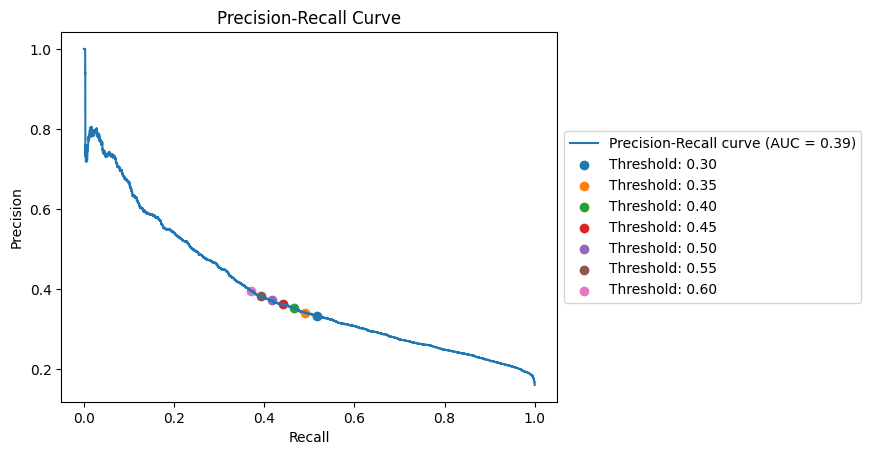

In [31]:
plot_precision_recall_curve(hard_scores, hard_labels)

## Easy performance

In [32]:
easy_scores = model.predict(easy_df.loc[:, ['utt', 'intent']].values)
easy_predictions = [label_mapping[score_max] for score_max in easy_scores.argmax(axis=1)]

easy_labels = easy_df['label']
print(classification_report(y_true=easy_labels, y_pred=easy_predictions))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

contradiction       0.93      0.55      0.69     25035
   entailment       0.60      0.44      0.51      5007
      neutral       0.00      0.00      0.00         0

     accuracy                           0.53     30042
    macro avg       0.51      0.33      0.40     30042
 weighted avg       0.88      0.53      0.66     30042



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-29-16e533d4f8fd>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = nn.functional.softmax(torch.tensor(scores)).numpy()


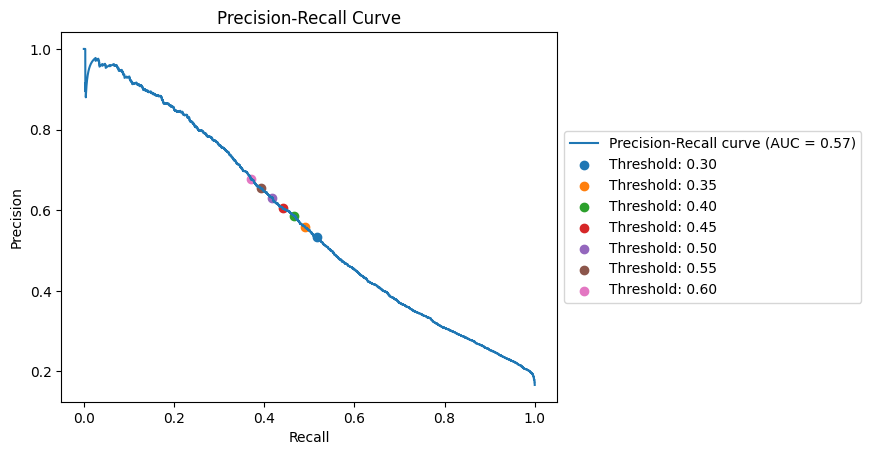

In [33]:
plot_precision_recall_curve(easy_scores, easy_labels)


## [20/100] Task 5. Train your own sentence pair model. 

To train your own sentence pair model, you can use the dataset created in Task 3. Train the model on the training set to make binary yes/no predictions and then evaluate the model on the validation set.

You may use any transformer encoder of your choice, such as BERT, RoBERTa, or ELECTRA. The input to the model should be a concatenation of the utterance and the verbalized intent label, separated by a special token such as [SEP].

Here is an example input format: utterance [SEP] verbalized_intent_label.

After training the model, you can use it to make predictions on the test set. Calculate performance metrics such as precision, recall, and F1-score and compare to the performance in Task 4.

The objective of this task is to explore how task-specific training improves the performance. 

In [34]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 10.8 MB/s eta 0:00:00


In [35]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from transformers import  BertTokenizer, BertModel, AutoModelForSequenceClassification 

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the BERT model and tokenizer
model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [36]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):

  def __init__(self, utterances, verbalized_intents, labels, tokenizer, max_len, seprator_token):
    self.utterances = utterances
    self.verbalized_intents = verbalized_intents
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.seprator_token = seprator_token
  
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, item):
    utt = self.utterances[item]
    verb_intent = self.verbalized_intents[item]
    sentence = utt + " " + self.seprator_token + " " + verb_intent

    target = self.labels[item]
    target = 0 if target=='contradiction' else 1 

    encoding = self.tokenizer(
      sentence,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_tensors='pt',
    )
    return {
      'text': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(target, dtype=torch.long)
    }


In [39]:
MAX_LEN = 32

train_ds = CustomDataset(
    utterances=train_full_df_hard['utt'].values,
    verbalized_intents=train_full_df_hard['intent'].values,
    labels=train_full_df_hard['label'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    seprator_token=tokenizer.sep_token)

val_ds = CustomDataset(
    utterances=validation_full_df_hard['utt'].values,
    verbalized_intents=validation_full_df_hard['intent'].values,
    labels=validation_full_df_hard['label'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    seprator_token=tokenizer.sep_token)

test_ds = CustomDataset(
    utterances=test_full_df_hard['utt'].values,
    verbalized_intents=test_full_df_hard['intent'].values,
    labels=test_full_df_hard['label'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    seprator_token=tokenizer.sep_token)

In [40]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='results',
    save_total_limit=2,
    load_best_model_at_end=True,
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    evaluation_strategy='steps',
    logging_steps=100,
    eval_steps=100,
    save_steps=100,
    warmup_steps=10,
)

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
        'precision': precision_score(labels, preds, average='weighted'),
        'recall': recall_score(labels, preds, average='weighted')
    }

In [42]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics = compute_metrics
    )
 
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.424400,0.388904,0.847703,0.792639,0.830901,0.847703
200,0.364600,0.329833,0.856940,0.822095,0.836693,0.856940
300,0.318100,0.290385,0.885126,0.867293,0.877418,0.885126
400,0.273000,0.240793,0.904548,0.901581,0.900140,0.904548
500,0.260200,0.212568,0.913311,0.911973,0.911042,0.913311
600,0.230000,0.200841,0.921601,0.921656,0.921711,0.921601
700,0.215900,0.178520,0.930365,0.930530,0.930705,0.930365
800,0.203200,0.169957,0.935339,0.932712,0.932966,0.935339
900,0.194100,0.158586,0.937865,0.938079,0.938316,0.937865
1000,0.169700,0.152013,0.941892,0.941344,0.940967,0.941892


TrainOutput(global_step=3372, training_loss=0.15595580434176987, metrics={'train_runtime': 1086.2454, 'train_samples_per_second': 198.524, 'train_steps_per_second': 3.104, 'total_flos': 3546177915260160.0, 'train_loss': 0.15595580434176987, 'epoch': 3.0})

In [43]:
trainer.evaluate(
    eval_dataset = test_ds
)

{'eval_loss': 0.11563274264335632,
 'eval_accuracy': 0.9622865147351974,
 'eval_f1': 0.9623477668791456,
 'eval_precision': 0.962414562560699,
 'eval_recall': 0.9622865147351974,
 'eval_runtime': 17.3204,
 'eval_samples_per_second': 1071.626,
 'eval_steps_per_second': 16.801,
 'epoch': 3.0}

## [10/10] Task 6. Wrap up. 

Summarize your findings from Tasks 1-5. What were the successful aspects of the zero-shot setup, and what were the challenges? How does training the model enhance its performance? What are the key insights you have gained from these tasks?

The challenges was to find good verbalize description for the intents, that can describe addtional intents. The training helped to improve the results significantly. The successfull aspects of the zero shot setup was to produce negative examples in 2 different ways. In our experiments we saw that the performance were better when we used the easy negative samples compare to the hard negative samples. We keep the hard negative samples on the training to create more rubost and strong model. 

The key insights we gain from the task are:

  *   First time to make zero shot classification, step by step.
  *   See the importance of good verbilize description for the intents.
  *   See the difference between hard & easy negative examples.
  



## Bonus tasks.  

Each of the main tasks offers numerous opportunities to experiment with different techniques. The downstream performance can be used as feedback to determine whether improvements have been made.

1. [10 bonus points] Task 2 provides an opportunity to try out different verbalizers and explore how the choice of verbalizer affects downstream performance.
2. [10 bonus points] In Task 3, you can experiment with different numbers of negative samples and explore alternative strategies for negative sampling.
3. [10 bonus points] Task 4 presents an opportunity to try out other NLI models from the Hugging Face model zoo.
3. [10 bonus points] For Task 5, you can model a generalized zero-shot setup where the training dataset only includes $N$ intents, but during testing, there are $N+M$ intents, where some of the intents are not seen during training. For instance, you can exclude one of the scenarios from the training data and evaluate whether the model can predict the intents from this scenario during testing.